### CV_Mini_Project

In [6]:
## ==================================================
## [1-1] 모듈 로딩
## ==================================================
import pandas as pd 
import numpy as np
import os
import cv2

## ML학습 관련
from sklearn.ensemble import RandomForestClassifier

## ML 데이터셋 및 전처리 관련
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

##- ML 학습 알고리즘 관련
from sklearn.linear_model import LogisticRegression

## ML CV 관련
from sklearn.model_selection import GridSearchCV

## ML 성능지표 관련
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## 시각화 관련
import matplotlib.pyplot as plt

In [2]:
## ==================================================
## [1-2] 데이터 준비 및 확인
## ==================================================
## 데이터
DATA_FILE1  = '../PrData/csv/White.csv'
DATA_FILE2 = '../PrData/csv/Yellow.csv'
DATA_FILE3 = '../PrData/csv/Black.csv'

## 데이터 로딩
df1 = pd.read_csv(DATA_FILE1, header=None)
df2 = pd.read_csv(DATA_FILE2, header=None)
df3 = pd.read_csv(DATA_FILE3, header=None)
df = pd.concat([df1, df2, df3], axis=0)

## 데이터 기본정보 확인
display( df.head(2) )
display( df.tail(2) )
df.info()


,0,1,2,3,4,5,6,7,8,9,...,14691,14692,14693,14694,14695,14696,14697,14698,14699,14700
0,white,253,252,255,250,250,253,249,252,251,...,206,247,212,208,244,209,205,242,207,203
1,white,227,214,203,228,213,201,228,210,198,...,221,235,232,230,240,239,238,239,238,240


,0,1,2,3,4,5,6,7,8,9,...,14691,14692,14693,14694,14695,14696,14697,14698,14699,14700
98,black,253,253,254,251,248,248,202,197,195,...,222,249,249,248,250,252,251,251,253,252
99,black,106,87,55,117,92,62,130,97,70,...,17,41,22,18,45,20,18,52,22,19


<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 99
Columns: 14701 entries, 0 to 14700
dtypes: int64(14700), object(1)
memory usage: 37.0+ MB


In [3]:
## ==================================================
## [2-1] 피쳐/타겟 분리
## ==================================================
featureDF = df[df.columns[1:]]
targetSR  = df[df.columns[0]]

print(f'featureDF:{featureDF.shape},  targetSR:{targetSR.shape}')

featureDF:(330, 14700),  targetSR:(330,)


In [4]:
## ==================================================
## [2-2] 학습용/테스트용 분리
## ==================================================
x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=targetSR)

print(f'[TRAIN] x_train:{x_train.shape},  y_train:{y_train.shape}')
print(f'[TEST] x_test:{x_test.shape},  y_test:{y_test.shape}')

[TRAIN] x_train:(264, 14700),  y_train:(264,)
[TEST] x_test:(66, 14700),  y_test:(66,)


In [7]:
# =========================================================
# [3-1] Pipeline (누수 방지: PCA는 CV fold의 train에서만 fit)
# =========================================================
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca",    PCA(random_state=42)),
    ("clf",    LogisticRegression(max_iter=3000,solver="lbfgs" ))
])

In [8]:
# =========================================================
# [3-2] 교차검증 위한 학습 모델 하이퍼라라미터 
# =========================================================
param_grid = {
    # PCA 차원: 정수(주성분 개수) 또는 누적분산 비율(0~1)
    "pca__n_components": [0.90, 0.95, 0.97, 40, 60, 80, 120],
    # LR 규제 강도(C): 클수록 규제 약함
    "clf__C": [0.1, 1.0, 3.0, 10.0],
}

In [9]:
# =========================================================
# [3-3] 사용자 정의 교차검증 설정
# =========================================================
## 자동 CV는 내부에서 random_state 고정하지 않음 
## 재현성 위해 설정 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [11]:
## ==========================================================================================
## [3-4] 교차검증
## -> refit 매개변수
##   * refit = True인 경우 : 전체 Train Dataset + 최적 하이퍼파라미터로 학습 후 estimator 반환
##   * refit = False인 경우: X ==> 개발자가 직접
##                                전체 Train Dataset + 최적 하이퍼파라미터로 학습 진행
## ==========================================================================================
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    verbose=1,
    refit=True
)

grid.fit(x_train, y_train)

print("\n[BEST PARAMS]")
print(grid.best_params_)
print("[BEST CV SCORE]", grid.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits

[BEST PARAMS]
{'clf__C': 3.0, 'pca__n_components': 120}
[BEST CV SCORE] 0.9016690856313498


In [20]:
# 성능 평가
train_score = grid.score(x_train, y_train)
test_score  = grid.score(x_test, y_test)

print(f'train_score : {train_score}   test_score : {test_score}')

train_score : 1.0   test_score : 0.9090909090909091


### 임의의 이미지로 예측해보기

In [21]:
def load_rgb_image(path):
    img = cv2.imread(path)              # 컬러로 읽기 (BGR)
    img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img = cv2.resize(img, (70, 70), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape(1, -1)             # (1, 14700)
    return img

In [22]:
img1   = load_rgb_image('../PrData/predict/pwhite.jpg')
img2_1 = load_rgb_image('../PrData/predict/pyellow.jpg')
img2_2 = load_rgb_image('../PrData/predict/pyellow2.jpg')
img3   = load_rgb_image('../PrData/predict/pblack.jpg')

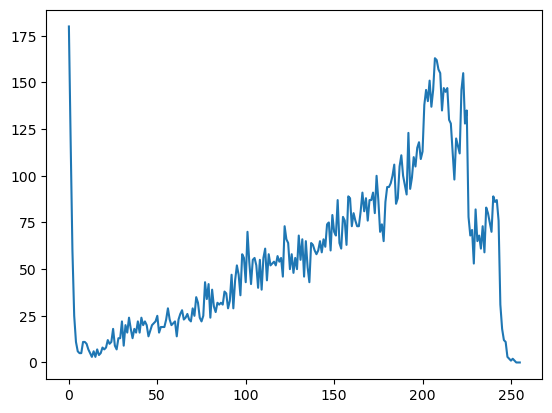

In [24]:
channels = cv2.split(img1)
colors = ('b')
for (ch,color) in zip(channels, colors):
    hist = cv2.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist)
plt.show()

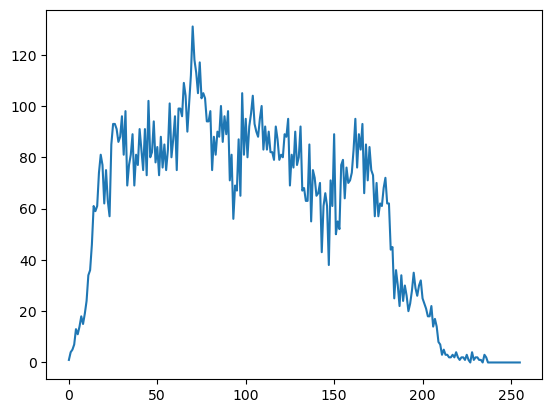

In [25]:
channels = cv2.split(img2_1)
for (ch,color) in zip(channels, colors):
    hist = cv2.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist)
plt.show()

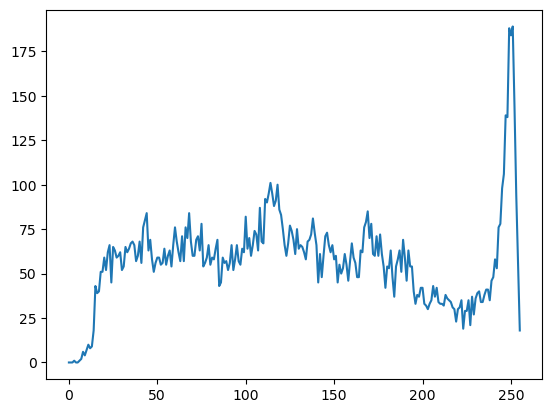

In [26]:
channels = cv2.split(img2_2)
for (ch,color) in zip(channels, colors):
    hist = cv2.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist)
plt.show()

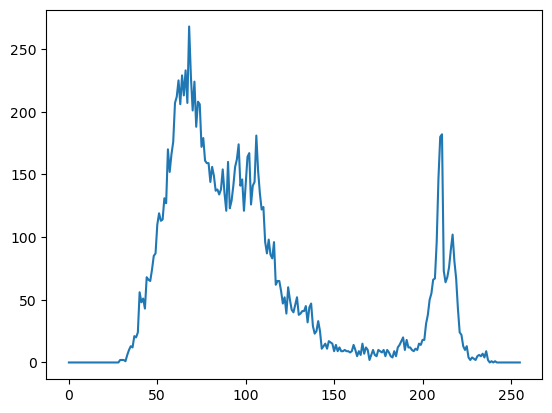

In [27]:
channels = cv2.split(img3)
for (ch,color) in zip(channels, colors):
    hist = cv2.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist)
plt.show()

In [28]:
## 백인 사진 넣어보기
pred_label = grid.predict(img1)
proba = grid.predict_proba(img1)

print("사진 예측 결과 :", pred_label[0])     

print(f'흑인일 확률 : {proba[0][0]*100}%')
print(f'백인일 확률 : {proba[0][1]*100}%')
print(f'황인일 확률 : {proba[0][2]*100}%')

사진 예측 결과 : white
흑인일 확률 : 2.5431430945197065e-06%
백인일 확률 : 99.99984973378173%
황인일 확률 : 0.00014772307516409467%


In [30]:
## 황인 사진 넣어보기
pred_label = grid.predict(img2_1)
proba = grid.predict_proba(img2_1)

print("사진 예측 결과 :", pred_label[0])     

print(f'흑인일 확률 : {proba[0][0]*100}%')
print(f'백인일 확률 : {proba[0][1]*100}%')
print(f'황인일 확률 : {proba[0][2]*100}%')

사진 예측 결과 : yellow
흑인일 확률 : 0.08619280526631191%
백인일 확률 : 1.6634235883778195e-09%
황인일 확률 : 99.91380719307026%


In [31]:
## 황인 사진 넣어보기
pred_label = grid.predict(img2_2)
proba = grid.predict_proba(img2_2)

print("사진 예측 결과 :", pred_label[0])     

print(f'흑인일 확률 : {proba[0][0]*100}%')
print(f'백인일 확률 : {proba[0][1]*100}%')
print(f'황인일 확률 : {proba[0][2]*100}%')

사진 예측 결과 : yellow
흑인일 확률 : 1.458057671945993e-13%
백인일 확률 : 1.5879481830000625e-09%
황인일 확률 : 99.99999999841191%


In [32]:
## 흑인 사진 넣어보기
pred_label = grid.predict(img3)
proba = grid.predict_proba(img3)

print("사진 예측 결과 :", pred_label[0])     

print(f'흑인일 확률 : {proba[0][0]*100}%')
print(f'백인일 확률 : {proba[0][1]*100}%')
print(f'황인일 확률 : {proba[0][2]*100}%')

사진 예측 결과 : black
흑인일 확률 : 99.96995900883687%
백인일 확률 : 0.0002642689726068483%
황인일 확률 : 0.029776722190521968%


In [34]:
img4   = load_rgb_image('../PrData/predict/winter.jpg')

## 하얀 연예인(윈터) 사진 넣어보기
pred_label = grid.predict(img4)
proba = grid.predict_proba(img4)

print("사진 예측 결과 :", pred_label[0])     

print(f'흑인일 확률 : {proba[0][0]*100}%')
print(f'백인일 확률 : {proba[0][1]*100}%')
print(f'황인일 확률 : {proba[0][2]*100}%')

사진 예측 결과 : white
흑인일 확률 : 1.1940788741592288e-10%
백인일 확률 : 99.99999999984954%
황인일 확률 : 3.1050993363812726e-11%


In [36]:
img5   = load_rgb_image('../PrData/predict/hyorin.jpg')

## 까만 연예인(효린) 사진 넣어보기
pred_label = grid.predict(img5)
proba = grid.predict_proba(img5)

print("사진 예측 결과 :", pred_label[0])     

print(f'흑인일 확률 : {proba[0][0]*100}%')
print(f'백인일 확률 : {proba[0][1]*100}%')
print(f'황인일 확률 : {proba[0][2]*100}%')

사진 예측 결과 : black
흑인일 확률 : 75.53697476618696%
백인일 확률 : 8.699876777943592e-06%
황인일 확률 : 24.463016533936262%


### rf보다 pca쪽이 더 높은 이유가 뭘까?
- 분산(정보)을 가장 잘 설명하는 방향 몇 개만 남김
- 배경/노이즈 -> 자연스럽게 제거
- 서로 비슷한 픽셀들 -> 하나의 축으로 압축 (차원 ↓)

-> 모델이 훈련 데이터의 세부 픽셀까지 외우다가 "피부색 분포 + 전체 색감 패턴"같은 본질만 학습